In [9]:
!pip install transformers torch torchvision Pillow pandas numpy datasets accelerate -q
!pip install medclip -q

import pandas as pd
import numpy as np
import torch
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import zipfile
import os
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

CSV_PATH = "/content/ALL IN ONE.csv"
ZIP_PATH = "/content/enhanced_mri_results.zip"
EXTRACT_PATH = "/content/mri_images"

print("Loading and processing CSV data...")

df = pd.read_csv(CSV_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

print("\nsummarization model")

summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    tokenizer="facebook/bart-large-cnn",
    framework="pt"
)

def create_patient_summary(row):
    clinical_text = f"""
    Patient ID: {row.get('PatientID', 'N/A')}
    Age: {row.get('Age', 'N/A')}
    Sex: {row.get('Sex', 'N/A')}
    Clinical Description: {row.get('Clinical_Description', 'N/A')}
    Date of Diagnosis: {row.get('Date_of_Diagnosis', 'N/A')}
    Tumor Type: {row.get('Tumor_Type', 'N/A')}
    ICD10 Code: {row.get('ICD10_Code', 'N/A')}
    Laboratory Findings:
    - WBC: {row.get('WBC_10^9_per_L', 'N/A')} 10^9/L
    - Hemoglobin: {row.get('Hemoglobin_g_per_dL', 'N/A')} g/dL
    - Platelets: {row.get('Platelets_10^9_per_L', 'N/A')} 10^9/L
    - CRP: {row.get('CRP_mg_per_L', 'N/A')} mg/L
    - ESR: {row.get('ESR_mm_per_hr', 'N/A')} mm/hr
    - Creatinine: {row.get('Creatinine_mg_per_dL', 'N/A')} mg/dL
    - ALT: {row.get('ALT_U_per_L', 'N/A')} U/L
    - AST: {row.get('AST_U_per_L', 'N/A')} U/L
    Imaging Findings: {row.get('Imaging_Findings', 'N/A')}
    Treatment: {row.get('Treatment', 'N/A')}
    Outcome: {row.get('Outcome', 'N/A')}
    """
    return clinical_text

def summarize_patient_data(row):
    full_text = create_patient_summary(row)

    clinical_desc = str(row.get('Clinical_Description', ''))
    if len(clinical_desc) > 50:
        try:
            summary = summarizer(clinical_desc, max_length=100, min_length=30, do_sample=False)
            clinical_summary = summary[0]['summary_text']
        except:
            clinical_summary = clinical_desc[:100] + "..."
    else:
        clinical_summary = clinical_desc

    return full_text, clinical_summary

print("\nProcessing MRI images")

if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

mri_images = glob.glob(os.path.join(EXTRACT_PATH, "**/*.png"), recursive=True) + \
             glob.glob(os.path.join(EXTRACT_PATH, "**/*.jpg"), recursive=True) + \
             glob.glob(os.path.join(EXTRACT_PATH, "**/*.jpeg"), recursive=True)

print(f"Found {len(mri_images)} MRI images")

if mri_images:
    print("Sample MRI images found:")
    for img in mri_images[:3]:
        print(f"  - {os.path.basename(img)}")

print("\nMedical image analysis model")

try:
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    image_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    print("BLIP model loaded successfully")
except Exception as e:
    print(f"BLIP model failed: {e}")
    from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
    processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    image_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    print("Fallback model loaded successfully")

def analyze_mri_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        if hasattr(processor, 'feature_extractor'):
            inputs = processor(image, return_tensors="pt")
            out = image_model.generate(**inputs, max_length=100, num_beams=5)
            caption = processor.decode(out[0], skip_special_tokens=True)
        else:
            pixel_values = processor(images=image, return_tensors="pt").pixel_values
            generated_ids = image_model.generate(pixel_values, max_length=100, num_beams=4)
            caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        enhanced_caption = f"MRI scan showing: {caption}. This appears to be a medical imaging study that requires clinical correlation with patient history and laboratory findings."

        return enhanced_caption

    except Exception as e:
        return f"Unable to analyze image: {str(e)}"

print("\ncomprehensive reports")

def generate_diagnostic_report(patient_data, mri_analysis, clinical_summary):

    report = f"""
    =========================================================================
    COMPREHENSIVE MEDICAL DIAGNOSTIC REPORT
    Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    =========================================================================

    PATIENT DEMOGRAPHICS:
    --------------------
    Patient ID: {patient_data.get('PatientID', 'N/A')}
    Age: {patient_data.get('Age', 'N/A')}
    Sex: {patient_data.get('Sex', 'N/A')}
    Date of Diagnosis: {patient_data.get('Date_of_Diagnosis', 'N/A')}

    CLINICAL SUMMARY:
    -----------------
    {clinical_summary}

    DIAGNOSIS:
    ----------
    Tumor Type: {patient_data.get('Tumor_Type', 'N/A')}
    ICD-10 Code: {patient_data.get('ICD10_Code', 'N/A')}

    LABORATORY FINDINGS:
    --------------------
    • Hematology:
      - WBC: {patient_data.get('WBC_10^9_per_L', 'N/A')} 10^9/L
      - Hemoglobin: {patient_data.get('Hemoglobin_g_per_dL', 'N/A')} g/dL
      - Platelets: {patient_data.get('Platelets_10^9_per_L', 'N/A')} 10^9/L

    • Inflammatory Markers:
      - CRP: {patient_data.get('CRP_mg_per_L', 'N/A')} mg/L
      - ESR: {patient_data.get('ESR_mm_per_hr', 'N/A')} mm/hr

    • Liver & Kidney Function:
      - Creatinine: {patient_data.get('Creatinine_mg_per_dL', 'N/A')} mg/dL
      - ALT: {patient_data.get('ALT_U_per_L', 'N/A')} U/L
      - AST: {patient_data.get('AST_U_per_L', 'N/A')} U/L

    RADIOLOGICAL ANALYSIS:
    ----------------------
    {mri_analysis}

    ORIGINAL IMAGING FINDINGS:
    {patient_data.get('Imaging_Findings', 'No specific imaging findings recorded')}

    TREATMENT AND OUTCOME:
    ----------------------
    Treatment Plan: {patient_data.get('Treatment', 'N/A')}
    Current Outcome: {patient_data.get('Outcome', 'N/A')}

    CLINICAL IMPRESSION:
    --------------------
    Based on the available clinical data and radiological findings, this case represents
    {patient_data.get('Tumor_Type', 'a tumor')}. The laboratory parameters and imaging
    characteristics should be correlated for comprehensive patient management.

    =========================================================================
    NOTE: This is an AI-generated report and should be verified by qualified
    healthcare professionals. Clinical correlation is essential.
    =========================================================================
    """
    return report

print("\nProcessing patients and generating reports")

for idx, (_, patient) in enumerate(df.head(3).iterrows()):
    print(f"\n{'='*60}")
    print(f"PROCESSING PATIENT {idx+1}: {patient.get('PatientID', 'Unknown')}")
    print(f"{'='*60}")

    full_text, clinical_summary = summarize_patient_data(patient)

    mri_analysis = "No MRI images available for analysis"
    if mri_images:
        sample_image = mri_images[idx % len(mri_images)]
        print(f"Analyzing MRI: {os.path.basename(sample_image)}")
        mri_analysis = analyze_mri_image(sample_image)
        print(f"MRI Analysis: {mri_analysis}")

    diagnostic_report = generate_diagnostic_report(patient, mri_analysis, clinical_summary)
    print(diagnostic_report)

    patient_id = patient.get('PatientID', f'patient_{idx+1}')
    filename = f"/content/diagnostic_report_{patient_id}.txt"
    with open(filename, 'w') as f:
        f.write(diagnostic_report)
    print(f"Report saved as: {filename}")

print(f"\nProcessed {min(3, len(df))} patients")
print(f"Reports saved in /content/ directory")
print(f"Total patients in dataset: {len(df)}")
print(f"Total MRI images available: {len(mri_images)}")

print("\nDATASET SUMMARY STATISTICS:")
print(f"• Total patients: {len(df)}")
if 'Age' in df.columns:
    print(f"• Age range: {df['Age'].min()} - {df['Age'].max()}")
if 'Tumor_Type' in df.columns:
    print(f"• Tumor types: {df['Tumor_Type'].nunique()} unique types")
    print(f"• Most common tumor: {df['Tumor_Type'].mode().iloc[0] if not df['Tumor_Type'].mode().empty else 'N/A'}")
if 'Sex' in df.columns:
    print(f"• Gender distribution: {df['Sex'].value_counts().to_dict()}")
print(f"• Available MRI images: {len(mri_images)}")

print("\nGenerated Reports:")
report_files = glob.glob("/content/diagnostic_report_*.txt")
for report in report_files:
    print(f"  - {os.path.basename(report)}")

Loading and processing CSV data...
Dataset shape: (100, 18)
Columns: ['PatientID', 'Age', 'Sex', 'Clinical_Description', 'Date_of_Diagnosis', 'Tumor_Type', 'ICD10_Code', 'WBC_10^9_per_L', 'Hemoglobin_g_per_dL', 'Platelets_10^9_per_L', 'CRP_mg_per_L', 'ESR_mm_per_hr', 'Creatinine_mg_per_dL', 'ALT_U_per_L', 'AST_U_per_L', 'Imaging_Findings', 'Treatment', 'Outcome']

First few rows:
  PatientID  Age     Sex                               Clinical_Description  \
0    PT1001   66   Other  66-yr Other. Presents with headache, seizures,...   
1    PT1002   52    Male  52-yr Male. Presents with fever, fatigue, recu...   
2    PT1003   60    Male  60-yr Male. Presents with fever, fatigue, recu...   
3    PT1004   51   Other  51-yr Other. Presents with fever, fatigue, rec...   
4    PT1005   58  Female  58-yr Female. Presents with weight loss, fatig...   

  Date_of_Diagnosis         Tumor_Type ICD10_Code  WBC_10^9_per_L  \
0        2024-11-29      Breast cancer        C50             8.2   
1   

Device set to use cpu



Processing MRI images
Found 400 MRI images
Sample MRI images found:
  - enhanced_Tumor (216).jpg
  - enhanced_Tumor (59).jpg
  - enhanced_Tumor (156).jpg

Medical image analysis model


Your max_length is set to 100, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


BLIP model loaded successfully

comprehensive reports

Processing patients and generating reports

PROCESSING PATIENT 1: PT1001
Analyzing MRI: enhanced_Tumor (216).jpg


Your max_length is set to 100, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


MRI Analysis: MRI scan showing: mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri. This appears to be a medical imaging study that requires clinical correlation with patient history and laboratory findings.

    COMPREHENSIVE MEDICAL DIAGNOSTIC REPORT
    Generated on: 2025-10-29 18:30:34
    
    PATIENT DEMOGRAPHICS:
    --------------------
    Patient ID: PT1001
    Age: 66
    Sex: Other
    Date of Diagnosis: 2024-11-29
    
    CLINICAL SUMMARY:
    -----------------
     66-yr Other. Presents with headache, seizures, focal weakness. Imaging: diffuse infiltration with lymphadenopathy. 67-year-old Other.
    
    DIAGNOSIS:
    ----------
    Tumor Type: Breast cancer
    ICD-10 Code: C50
    
    LABORATORY FINDINGS:
    --------------------
    • Hematology:
      - WBC: 8.2 10^9/L
      - Hemoglobin: 15.2 g/dL  
      - Platelets: 231 10^9/L
      
    • Inflammatory Markers:
      - CRP: 0.3 mg/L
      - ESR: 25 mm/hr
      
    • Liver & Kid

Your max_length is set to 100, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


MRI Analysis: MRI scan showing: mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri mri. This appears to be a medical imaging study that requires clinical correlation with patient history and laboratory findings.

    COMPREHENSIVE MEDICAL DIAGNOSTIC REPORT
    Generated on: 2025-10-29 18:30:53
    
    PATIENT DEMOGRAPHICS:
    --------------------
    Patient ID: PT1002
    Age: 52
    Sex: Male
    Date of Diagnosis: 2021-11-27
    
    CLINICAL SUMMARY:
    -----------------
    52-yr Male. Presents with fever, fatigue, recurrent infections. Imaging: multiple metastatic nodules on ct chest. Back to Mail Online home. Back To the page you came from.
    
    DIAGNOSIS:
    ----------
    Tumor Type: Pancreatic cancer
    ICD-10 Code: C25
    
    LABORATORY FINDINGS:
    --------------------
    • Hematology:
      - WBC: 5.1 10^9/L
      - Hemoglobin: 10.9 g/dL  
      - Platelets: 205 10^9/L
      
    • Inflammatory Markers:
      - CRP: 4.7 mg/L
      

Loading and processing CSV data
Dataset shape: (100, 18)
Columns: ['PatientID', 'Age', 'Sex', 'Clinical_Description', 'Date_of_Diagnosis', 'Tumor_Type', 'ICD10_Code', 'WBC_10^9_per_L', 'Hemoglobin_g_per_dL', 'Platelets_10^9_per_L', 'CRP_mg_per_L', 'ESR_mm_per_hr', 'Creatinine_mg_per_dL', 'ALT_U_per_L', 'AST_U_per_L', 'Imaging_Findings', 'Treatment', 'Outcome']
Available Patient IDs: ['PT1001', 'PT1002', 'PT1003', 'PT1004', 'PT1005', 'PT1006', 'PT1007', 'PT1008', 'PT1009', 'PT1010', 'PT1011', 'PT1012', 'PT1013', 'PT1014', 'PT1015', 'PT1016', 'PT1017', 'PT1018', 'PT1019', 'PT1020', 'PT1021', 'PT1022', 'PT1023', 'PT1024', 'PT1025', 'PT1026', 'PT1027', 'PT1028', 'PT1029', 'PT1030', 'PT1031', 'PT1032', 'PT1033', 'PT1034', 'PT1035', 'PT1036', 'PT1037', 'PT1038', 'PT1039', 'PT1040', 'PT1041', 'PT1042', 'PT1043', 'PT1044', 'PT1045', 'PT1046', 'PT1047', 'PT1048', 'PT1049', 'PT1050', 'PT1051', 'PT1052', 'PT1053', 'PT1054', 'PT1055', 'PT1056', 'PT1057', 'PT1058', 'PT1059', 'PT1060', 'PT1061', 'PT

Device set to use cpu



Processing MRI images
Found 400 MRI images
Created mapping for 100 patients

 Medical image analysis model
BLIP model loaded successfully

MEDICAL DIAGNOSTIC REPORT SYSTEM
Total patients in database: 100
Total MRI images available: 400
Available Patient IDs: ['PT1001', 'PT1002', 'PT1003', 'PT1004', 'PT1005', 'PT1006', 'PT1007', 'PT1008', 'PT1009', 'PT1010', 'PT1011', 'PT1012', 'PT1013', 'PT1014', 'PT1015', 'PT1016', 'PT1017', 'PT1018', 'PT1019', 'PT1020', 'PT1021', 'PT1022', 'PT1023', 'PT1024', 'PT1025', 'PT1026', 'PT1027', 'PT1028', 'PT1029', 'PT1030', 'PT1031', 'PT1032', 'PT1033', 'PT1034', 'PT1035', 'PT1036', 'PT1037', 'PT1038', 'PT1039', 'PT1040', 'PT1041', 'PT1042', 'PT1043', 'PT1044', 'PT1045', 'PT1046', 'PT1047', 'PT1048', 'PT1049', 'PT1050', 'PT1051', 'PT1052', 'PT1053', 'PT1054', 'PT1055', 'PT1056', 'PT1057', 'PT1058', 'PT1059', 'PT1060', 'PT1061', 'PT1062', 'PT1063', 'PT1064', 'PT1065', 'PT1066', 'PT1067', 'PT1068', 'PT1069', 'PT1070', 'PT1071', 'PT1072', 'PT1073', 'PT1074',

Your max_length is set to 100, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)



SEARCHING FOR PATIENT ID: PT1004

GENERATING CLINICAL SUMMARY
Clinical Summary:  51-yr Other. Presents with fever, fatigue, recurrent infections. Imaging: hypermetabolic lesion on pet-ct. 67-year-old Other.

ANALYZING MRI IMAGE
MRI Image found: enhanced_Normal (169).jpg
MRI Analysis Completed

DISPLAYING MRI SCAN


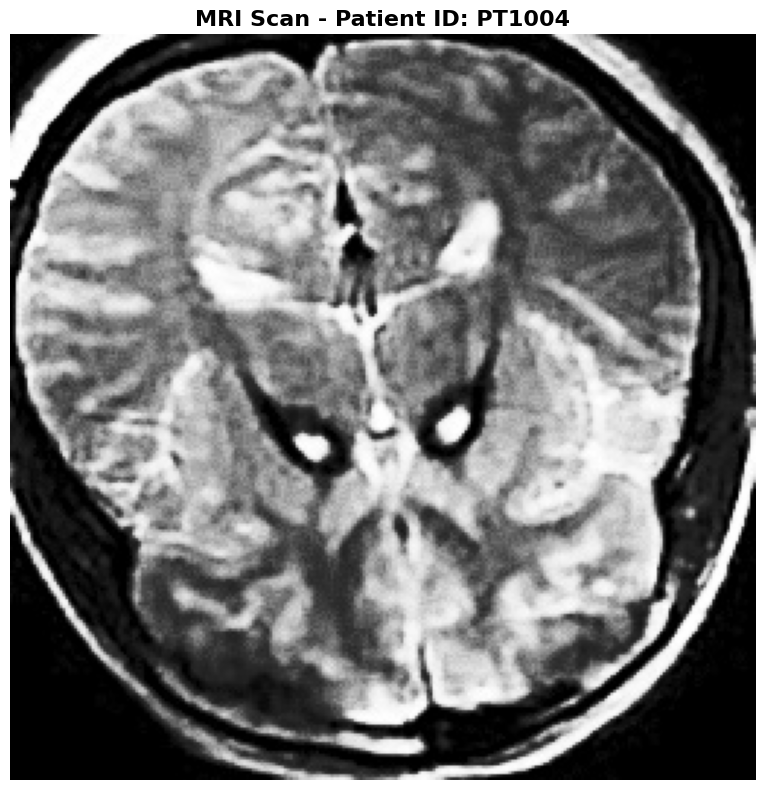


GENERATING DIAGNOSTIC REPORT

COMPREHENSIVE DIAGNOSTIC REPORT

    COMPREHENSIVE MEDICAL DIAGNOSTIC REPORT
    Generated on: 2025-10-29 18:43:51
    
    PATIENT DEMOGRAPHICS:
    --------------------
    Patient ID: PT1004
    Age: 51
    Sex: Other
    Date of Diagnosis: 2021-03-22
    
    CLINICAL SUMMARY:
    -----------------
     51-yr Other. Presents with fever, fatigue, recurrent infections. Imaging: hypermetabolic lesion on pet-ct. 67-year-old Other.
    
    DIAGNOSIS:
    ----------
    Tumor Type: Pancreatic cancer
    ICD-10 Code: C25
    
    LABORATORY FINDINGS:
    --------------------
    • Hematology:
      - WBC: 5.9 10^9/L
      - Hemoglobin: 14.0 g/dL  
      - Platelets: 152 10^9/L
      
    • Inflammatory Markers:
      - CRP: 1.9 mg/L
      - ESR: 52 mm/hr
      
    • Liver & Kidney Function:
      - Creatinine: 1.3 mg/dL
      - ALT: 39.4 U/L
      - AST: 47.9 U/L
    
    RADIOLOGICAL ANALYSIS:
    ----------------------
    MRI scan showing: mri mri mri m

In [ ]:
!pip install transformers torch torchvision Pillow pandas numpy datasets accelerate -q
!pip install medclip -q
!pip install matplotlib -q

import pandas as pd
import numpy as np
import torch
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import zipfile
import os
import glob
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

CSV_PATH = "/content/ALL IN ONE.csv"
ZIP_PATH = "/content/enhanced_mri_results.zip"
EXTRACT_PATH = "/content/mri_images"

print("Loading and processing CSV data")

df = pd.read_csv(CSV_PATH)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

if 'PatientID' in df.columns:
    print(f"Available Patient IDs: {df['PatientID'].tolist()}")
else:
    print("No PatientID column found in the dataset")
    print("Available columns:", df.columns.tolist())

print("\nLoading summarization model")

summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    tokenizer="facebook/bart-large-cnn",
    framework="pt"
)

def create_patient_summary(row):
    """Create a detailed patient summary from CSV data"""
    clinical_text = f"""
    Patient ID: {row.get('PatientID', 'N/A')}
    Age: {row.get('Age', 'N/A')}
    Sex: {row.get('Sex', 'N/A')}
    Clinical Description: {row.get('Clinical_Description', 'N/A')}
    Date of Diagnosis: {row.get('Date_of_Diagnosis', 'N/A')}
    Tumor Type: {row.get('Tumor_Type', 'N/A')}
    ICD10 Code: {row.get('ICD10_Code', 'N/A')}
    Laboratory Findings:
    - WBC: {row.get('WBC_10^9_per_L', 'N/A')} 10^9/L
    - Hemoglobin: {row.get('Hemoglobin_g_per_dL', 'N/A')} g/dL
    - Platelets: {row.get('Platelets_10^9_per_L', 'N/A')} 10^9/L
    - CRP: {row.get('CRP_mg_per_L', 'N/A')} mg/L
    - ESR: {row.get('ESR_mm_per_hr', 'N/A')} mm/hr
    - Creatinine: {row.get('Creatinine_mg_per_dL', 'N/A')} mg/dL
    - ALT: {row.get('ALT_U_per_L', 'N/A')} U/L
    - AST: {row.get('AST_U_per_L', 'N/A')} U/L
    Imaging Findings: {row.get('Imaging_Findings', 'N/A')}
    Treatment: {row.get('Treatment', 'N/A')}
    Outcome: {row.get('Outcome', 'N/A')}
    """
    return clinical_text

def summarize_patient_data(row):
    full_text = create_patient_summary(row)
    clinical_desc = str(row.get('Clinical_Description', ''))
    if len(clinical_desc) > 50:
        try:
            summary = summarizer(clinical_desc, max_length=100, min_length=30, do_sample=False)
            clinical_summary = summary[0]['summary_text']
        except:
            clinical_summary = clinical_desc[:100] + "..."
    else:
        clinical_summary = clinical_desc

    return full_text, clinical_summary

print("\nProcessing MRI images")

if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

mri_images = glob.glob(os.path.join(EXTRACT_PATH, "**/*.png"), recursive=True) + \
             glob.glob(os.path.join(EXTRACT_PATH, "**/*.jpg"), recursive=True) + \
             glob.glob(os.path.join(EXTRACT_PATH, "**/*.jpeg"), recursive=True)

print(f"Found {len(mri_images)} MRI images")

patient_image_mapping = {}
if 'PatientID' in df.columns:
    for image_path in mri_images:
        filename = os.path.basename(image_path).lower()
        for patient_id in df['PatientID'].astype(str):
            if patient_id.lower() in filename:
                patient_image_mapping[patient_id] = image_path
                break

    if len(patient_image_mapping) < len(df) and len(mri_images) > 0:
        for idx, patient_id in enumerate(df['PatientID'].astype(str)):
            if patient_id not in patient_image_mapping and idx < len(mri_images):
                patient_image_mapping[patient_id] = mri_images[idx]

print(f"Created mapping for {len(patient_image_mapping)} patients")
print("\n Medical image analysis model")

try:
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    image_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    print("BLIP model loaded successfully")
except Exception as e:
    print(f"BLIP model failed: {e}")
    from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
    processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    image_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
    print("Fallback model loaded successfully")

def analyze_mri_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')

        if hasattr(processor, 'feature_extractor'):
            inputs = processor(image, return_tensors="pt")
            out = image_model.generate(**inputs, max_length=100, num_beams=5)
            caption = processor.decode(out[0], skip_special_tokens=True)
        else:
            pixel_values = processor(images=image, return_tensors="pt").pixel_values
            generated_ids = image_model.generate(pixel_values, max_length=100, num_beams=4)
            caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        enhanced_caption = f"MRI scan showing: {caption}. This appears to be a medical imaging study that requires clinical correlation with patient history and laboratory findings."

        return enhanced_caption, image

    except Exception as e:
        return f"Unable to analyze image: {str(e)}", None

def display_mri_image(image, patient_id):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f"MRI Scan - Patient ID: {patient_id}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def generate_diagnostic_report(patient_data, mri_analysis, clinical_summary):

    report = f"""
    =========================================================================
    COMPREHENSIVE MEDICAL DIAGNOSTIC REPORT
    Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    =========================================================================

    PATIENT DEMOGRAPHICS:
    --------------------
    Patient ID: {patient_data.get('PatientID', 'N/A')}
    Age: {patient_data.get('Age', 'N/A')}
    Sex: {patient_data.get('Sex', 'N/A')}
    Date of Diagnosis: {patient_data.get('Date_of_Diagnosis', 'N/A')}

    CLINICAL SUMMARY:
    -----------------
    {clinical_summary}

    DIAGNOSIS:
    ----------
    Tumor Type: {patient_data.get('Tumor_Type', 'N/A')}
    ICD-10 Code: {patient_data.get('ICD10_Code', 'N/A')}

    LABORATORY FINDINGS:
    --------------------
    • Hematology:
      - WBC: {patient_data.get('WBC_10^9_per_L', 'N/A')} 10^9/L
      - Hemoglobin: {patient_data.get('Hemoglobin_g_per_dL', 'N/A')} g/dL
      - Platelets: {patient_data.get('Platelets_10^9_per_L', 'N/A')} 10^9/L

    • Inflammatory Markers:
      - CRP: {patient_data.get('CRP_mg_per_L', 'N/A')} mg/L
      - ESR: {patient_data.get('ESR_mm_per_hr', 'N/A')} mm/hr

    • Liver & Kidney Function:
      - Creatinine: {patient_data.get('Creatinine_mg_per_dL', 'N/A')} mg/dL
      - ALT: {patient_data.get('ALT_U_per_L', 'N/A')} U/L
      - AST: {patient_data.get('AST_U_per_L', 'N/A')} U/L

    RADIOLOGICAL ANALYSIS:
    ----------------------
    {mri_analysis}

    ORIGINAL IMAGING FINDINGS:
    {patient_data.get('Imaging_Findings', 'No specific imaging findings recorded')}

    TREATMENT AND OUTCOME:
    ----------------------
    Treatment Plan: {patient_data.get('Treatment', 'N/A')}
    Current Outcome: {patient_data.get('Outcome', 'N/A')}

    CLINICAL IMPRESSION:
    --------------------
    Based on the available clinical data and radiological findings, this case represents
    {patient_data.get('Tumor_Type', 'a tumor')}. The laboratory parameters and imaging
    characteristics should be correlated for comprehensive patient management.

    =========================================================================
    NOTE: This is an AI-generated report and should be verified by qualified
    healthcare professionals. Clinical correlation is essential.
    =========================================================================
    """
    return report

def get_patient_report(patient_id):
    print(f"\n{'='*80}")
    print(f"SEARCHING FOR PATIENT ID: {patient_id}")
    print(f"{'='*80}")

    if 'PatientID' not in df.columns:
        print("Error: No PatientID column found in the dataset!")
        return

    patient_data = df[df['PatientID'].astype(str) == str(patient_id)]

    if patient_data.empty:
        print(f"Patient ID '{patient_id}' not found in database!")
        print(f"Available Patient IDs: {df['PatientID'].tolist()}")
        return

    patient = patient_data.iloc[0]

    print("\nGENERATING CLINICAL SUMMARY")
    full_text, clinical_summary = summarize_patient_data(patient)
    print(f"Clinical Summary: {clinical_summary}")

    print("\nANALYZING MRI IMAGE")
    mri_analysis = "No MRI images available for analysis"
    mri_image = None

    if patient_id in patient_image_mapping:
        image_path = patient_image_mapping[patient_id]
        print(f"MRI Image found: {os.path.basename(image_path)}")
        mri_analysis, mri_image = analyze_mri_image(image_path)
        print(f"MRI Analysis Completed")

        if mri_image:
            print("\nDISPLAYING MRI SCAN")
            display_mri_image(mri_image, patient_id)
    else:
        print("No specific MRI image found for this patient")
        if mri_images:
            sample_image = mri_images[0]
            mri_analysis, mri_image = analyze_mri_image(sample_image)
            if mri_image:
                display_mri_image(mri_image, f"{patient_id} (Sample Image)")

    print("\nGENERATING DIAGNOSTIC REPORT")
    diagnostic_report = generate_diagnostic_report(patient, mri_analysis, clinical_summary)
    print("\n" + "="*80)
    print("COMPREHENSIVE DIAGNOSTIC REPORT")
    print("="*80)
    print(diagnostic_report)

    filename = f"/content/diagnostic_report_{patient_id}.txt"
    with open(filename, 'w') as f:
        f.write(diagnostic_report)
    print(f"Report saved as: {filename}")

    return diagnostic_report

print("\n" + "="*80)
print("MEDICAL DIAGNOSTIC REPORT SYSTEM")
print("="*80)
print(f"Total patients in database: {len(df)}")
print(f"Total MRI images available: {len(mri_images)}")

if 'PatientID' in df.columns:
    print(f"Available Patient IDs: {df['PatientID'].tolist()}")
else:
    print("No PatientID column found! Using index-based identification.")

while True:
    print("\n" + "="*50)

    if 'PatientID' in df.columns:
        patient_id = input("\nEnter Patient ID (or 'quit' to exit): ").strip()
    else:
        print("No PatientID column found. Using index numbers instead.")
        print(f"Available indices: 0 to {len(df)-1}")
        patient_id = input("\nEnter Patient Index (0 to {} or 'quit' to exit): ".format(len(df)-1)).strip()

    if patient_id.lower() in ['quit', 'exit', 'q']:
        print("Thank you for using the Medical Diagnostic System!")
        break

    if not patient_id:
        print("Please enter a valid Patient ID")
        continue

    get_patient_report(patient_id)

    print("\n" + "="*50)
    continue_choice = input("\nWould you like to search for another patient? (y/n): ").strip().lower()
    if continue_choice not in ['y', 'yes', 'ye']:
        print("Thank you for using the Medical Diagnostic System!")
        break

print(f"\nSession completed! All reports are saved in /content/ directory")
report_files = glob.glob('/content/diagnostic_report_*.txt')
print(f"Generated reports: {report_files if report_files else 'No reports generated'}")